In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score
from sklearn.model_selection import train_test_split

In [2]:
path_normal = "/kaggle/input/wadi-data/WADI_14days_new.csv"
path_attack = "/kaggle/input/wadi-data/WADI_attackdataLABLE.csv"

normal_df = pd.read_csv(path_normal, index_col=0).reset_index(drop=True)
attack_df = pd.read_csv(path_attack, index_col=0)
attack_df.columns = attack_df.iloc[0]
attack_df = attack_df[1:].reset_index(drop=True)

/tmp/ipykernel_35/4255207485.py:5: DtypeWarning: Columns (0,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130) have mixed types. Specify dtype option on import or set low_memory=False.
  attack_df = pd.read_csv(path_attack, index_col=0)


In [3]:
# Remove unused columns and NaN
null_cols = ['2_LS_001_AL','2_LS_002_AL','2_P_001_STATUS','2_P_002_STATUS','2B_AIT_002_PV']
normal_df.drop(columns=null_cols, inplace=True)
attack_df.drop(columns=null_cols, inplace=True)
attack_df.dropna(axis=0, inplace=True)

# Fill NaN for some columns in normal_df
fill_cols = ['1_AIT_002_PV','2B_AIT_004_PV','3_AIT_004_PV','1_AIT_004_PV']
normal_df[fill_cols] = normal_df[fill_cols].bfill()

# Define feature columns
train_cols = [c for c in normal_df.columns if c not in ['Date','Time']]
normal_df[train_cols] = normal_df[train_cols].astype(float)
attack_df[train_cols] = attack_df[train_cols].astype(float)

# Point-wise labels from attack_df
point_labels = pd.to_numeric(
    attack_df['Attack LABLE (1:No Attack, -1:Attack)'], errors='coerce'
).astype(int).map({1:0, -1:1}).values
attack_df.drop(columns=['Attack LABLE (1:No Attack, -1:Attack)'], inplace=True)

In [4]:
# Scale data
scaler = MinMaxScaler()
normal_scaled = scaler.fit_transform(normal_df[train_cols])
attack_scaled = scaler.transform(attack_df[train_cols])

print(f"Normal data shape: {normal_scaled.shape}")
print(f"Attack data shape: {attack_scaled.shape}")
print(f"Point labels shape: {point_labels.shape}")

Normal data shape: (784571, 122)
Attack data shape: (172801, 122)
Point labels shape: (172801,)


In [5]:
WINDOW_SIZE = 60
STEP_SIZE = 10

def create_windows(arr, window_size, step_size):
    windows = []
    for start in range(0, len(arr)-window_size+1, step_size):
        windows.append(arr[start:start+window_size])
    return np.stack(windows)

# Create windows for training (only for model fitting)
data_windows = create_windows(attack_scaled, WINDOW_SIZE, STEP_SIZE)
label_windows = create_windows(point_labels.reshape(-1,1), WINDOW_SIZE, STEP_SIZE).squeeze(-1)
window_labels = (label_windows.sum(axis=1) > 0).astype(int)

In [6]:
# Flatten windows for model input
m = WINDOW_SIZE * len(train_cols)
data_flat = data_windows.reshape(-1, m)

# Split train/test windows: train only on normal windows
X_train, X_test_windows, y_train, y_test_windows = train_test_split(
    data_flat, window_labels,
    test_size=0.5,
    stratify=window_labels,
    random_state=42
)
X_train_norm = X_train[y_train==0]


In [7]:
class CERELayer(nn.Module):
    def __init__(self, input_dim, output_dim, r):
        super().__init__()
        self.input_dim, self.output_dim, self.r = input_dim, output_dim, r
        self.W0 = nn.Parameter(torch.randn(input_dim, output_dim), requires_grad=False)
        self.p  = nn.Parameter(torch.randn(r, input_dim), requires_grad=False)
        self.q  = nn.Parameter(torch.randn(r, output_dim), requires_grad=False)
    def forward(self, X):
        b = X.size(0)
        X_exp = X.unsqueeze(1).expand(-1, self.r, -1)
        p_exp = self.p.unsqueeze(0).expand(b, -1, -1)
        Xp = X_exp * p_exp
        M_flat = Xp.view(b*self.r, self.input_dim) @ self.W0
        M = M_flat.view(b, self.r, self.output_dim)
        q_exp = self.q.unsqueeze(0).expand(b, -1, -1)
        return M * q_exp

class iNode:
    def __init__(self, depth=0):
        self.left=self.right=None; self.split_dim=self.split_val=None
        self.depth=depth; self.is_leaf=False; self.size=0

class iTree:
    def __init__(self, data): self.root=self._build(data,0)
    def _build(self,data,depth):
        n,m=data.shape; node=iNode(depth); node.size=n
        if n<=1: node.is_leaf=True; return node
        q=np.random.randint(m); vals=data[:,q]; mn, mx=vals.min(), vals.max()
        if mn==mx: node.is_leaf=True; return node
        eta=np.random.uniform(mn,mx); node.split_dim, node.split_val=q, eta
        left=data[vals<=eta]; right=data[vals>eta]
        if len(left)==0 or len(right)==0: node.is_leaf=True; return node
        node.left=self._build(left,depth+1); node.right=self._build(right,depth+1)
        return node
    def path_dev(self,x):
        node, h, dev=self.root,0,[]
        while node and not node.is_leaf:
            q, eta=node.split_dim,node.split_val; h+=1; dev.append(abs(x[q]-eta))
            node = node.left if x[q]<=eta else node.right
        return h, np.mean(dev) if dev else 0

class iForestDEAS:
    def __init__(self,n_trees=20, subsample_size=64):
        self.n_trees=n_trees; self.subsample=subsample_size; self.trees=[]
        self.c = lambda n: 2*(np.log(n-1)+0.5772156649)-2*(n-1)/n if n>1 else 0
    def fit(self,X):
        n=X.shape[0]; self.trees=[]
        for _ in range(self.n_trees):
            idx=np.random.choice(n, min(n,self.subsample), replace=False)
            self.trees.append(iTree(X[idx]))
    def score(self,X):
        n=X.shape[0]; scores=[]
        for x in X:
            depths, devs = zip(*(t.path_dev(x) for t in self.trees))
            Eh, Eg=np.mean(depths), np.mean(devs)
            scores.append((2**(-Eh/self.c(self.subsample))) * Eg)
        return np.array(scores)

class DeepIsolationForestCERE:
    def __init__(self, input_dim, d=16, hidden_dim=16, r=10, n_trees=20, subsample_size=64):
        self.cere = CERELayer(input_dim, hidden_dim, r)
        self.fc   = nn.Linear(hidden_dim, d)
        nn.init.normal_(self.fc.weight)
        self.if_deas = iForestDEAS(n_trees, subsample_size)
        self.r, self.hidden_dim = r, hidden_dim
    def fit(self,X):
        Zh = self.cere(torch.from_numpy(X.astype(np.float32)))
        n=self.r*X.shape[0]; Zh_flat=Zh.view(n,self.hidden_dim).detach().numpy()
        Zd = self.fc(torch.from_numpy(Zh_flat)).detach().numpy()
        self.if_deas.fit(Zd)
    def score_windows(self,X):
        # Original window-based scoring
        Zh = self.cere(torch.from_numpy(X.astype(np.float32)))
        n=self.r*X.shape[0]; Zh_flat=Zh.view(n,self.hidden_dim).detach().numpy()
        Zd = self.fc(torch.from_numpy(Zh_flat)).detach().numpy()
        s = self.if_deas.score(Zd)
        return s.reshape(-1,self.r).mean(axis=1)
    
    def score_points_optimized(self, X_points, step_size=1):
        """
        Optimized point-wise scoring using efficient sliding windows
        """
        n_points = X_points.shape[0]
        
        # Create all possible windows with step_size
        all_windows = []
        window_point_mapping = []  # Maps each window to the points it covers
        
        for start in range(0, n_points - WINDOW_SIZE + 1, step_size):
            window = X_points[start:start+WINDOW_SIZE].flatten()
            all_windows.append(window)
            # This window covers points from start to start+WINDOW_SIZE-1
            window_point_mapping.append((start, start + WINDOW_SIZE - 1))
        
        if not all_windows:
            return np.zeros(n_points)
            
        # Score all windows at once (much faster)
        print(f"Scoring {len(all_windows)} windows...")
        all_windows = np.array(all_windows)
        window_scores = self.score_windows(all_windows)
        
        # Map window scores back to points
        point_scores = np.zeros(n_points)
        point_counts = np.zeros(n_points)  # Count how many windows cover each point
        
        for i, (start, end) in enumerate(window_point_mapping):
            for point_idx in range(start, end + 1):
                point_scores[point_idx] += window_scores[i]
                point_counts[point_idx] += 1
        
        # Average scores for points covered by multiple windows
        # For points not covered by any window, use nearest window score
        for i in range(n_points):
            if point_counts[i] > 0:
                point_scores[i] /= point_counts[i]
            else:
                # Find nearest window
                if i < WINDOW_SIZE // 2:
                    point_scores[i] = window_scores[0]  # Use first window
                else:
                    point_scores[i] = window_scores[-1]  # Use last window
        
        return point_scores
    
    def score_points_simple(self, X_points):
        """
        Simple approach: score overlapping windows and interpolate
        Much faster but slightly less accurate
        """
        n_points = X_points.shape[0]
        
        # Create windows with overlap
        step_size = WINDOW_SIZE // 4  # 75% overlap for better coverage
        windows = []
        window_centers = []
        
        for start in range(0, n_points - WINDOW_SIZE + 1, step_size):
            window = X_points[start:start+WINDOW_SIZE].flatten()
            windows.append(window)
            window_centers.append(start + WINDOW_SIZE // 2)  # Center of window
        
        if not windows:
            return np.zeros(n_points)
        
        # Score all windows
        windows = np.array(windows)
        window_scores = self.score_windows(windows)
        
        # Interpolate scores to all points
        point_indices = np.arange(n_points)
        point_scores = np.interp(point_indices, window_centers, window_scores)
        
        return point_scores

In [8]:
# Train the model
CONTAMINATION = 0.01
m = X_train_norm.shape[1]
dif_model = DeepIsolationForestCERE(
    input_dim=m,
    d=32,
    hidden_dim=32,
    r=30,
    n_trees=100,
    subsample_size=128
)

print("Training on normal windows...")
dif_model.fit(X_train_norm)

# Calculate threshold using normal windows
scores_train_norm = dif_model.score_windows(X_train_norm)
thresh = np.percentile(scores_train_norm, 100*(1-CONTAMINATION))
print(f"Threshold = {thresh:.4f}")

print("Performing point-wise evaluation...")

print("Using simple interpolation method...")
point_scores = dif_model.score_points_simple(attack_scaled)


y_pred_points = (point_scores > thresh).astype(int)

# Evaluation metrics
print("\n=== POINT-WISE EVALUATION RESULTS ===")
print(f"Total points evaluated: {len(point_labels)}")
print(f"Normal points: {np.sum(point_labels == 0)}")
print(f"Attack points: {np.sum(point_labels == 1)}")
print(f"Predicted normal: {np.sum(y_pred_points == 0)}")
print(f"Predicted attack: {np.sum(y_pred_points == 1)}")

# Classification report
print("\nClassification Report:")
print(classification_report(point_labels, y_pred_points, digits=4))

# Detailed metrics for attack class
tp_f1 = f1_score(point_labels, y_pred_points, pos_label=1)
tp_recall = recall_score(point_labels, y_pred_points, pos_label=1)

Training on normal windows...
Threshold = 126.7287
Performing point-wise evaluation...
Using simple interpolation method...

=== POINT-WISE EVALUATION RESULTS ===
Total points evaluated: 172801
Normal points: 162824
Attack points: 9977
Predicted normal: 167253
Predicted attack: 5548

Classification Report:
              precision    recall  f1-score   support

           0     0.9621    0.9883    0.9750    162824
           1     0.6568    0.3652    0.4694      9977

    accuracy                         0.9523    172801
   macro avg     0.8095    0.6768    0.7222    172801
weighted avg     0.9445    0.9523    0.9459    172801



NameError: name 'roc_auc_score' is not defined


Attack Detection Metrics:
Class 1 (Attack) Recall: 0.3652
Class 1 (Attack) F1-score: 0.4694
ROC-AUC: 0.7691
PR-AUC: 0.4609


Text(220.72222222222223, 0.5, 'Actual')

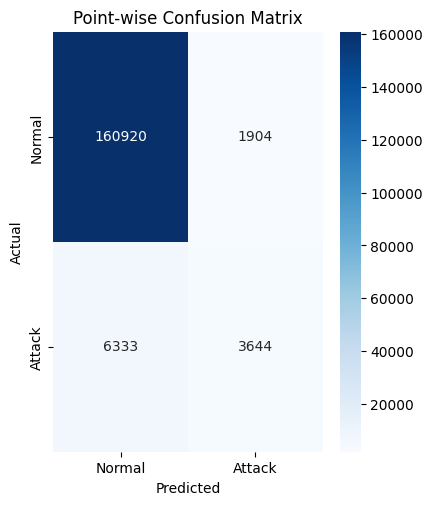

In [12]:
from sklearn.metrics import (classification_report, confusion_matrix, f1_score, recall_score, 
                             roc_auc_score, average_precision_score, roc_curve, precision_recall_curve)# ROC-AUC and PR-AUC calculations
roc_auc = roc_auc_score(point_labels, point_scores)
pr_auc = average_precision_score(point_labels, point_scores)

print(f"\nAttack Detection Metrics:")
print(f"Class 1 (Attack) Recall: {tp_recall:.4f}")
print(f"Class 1 (Attack) F1-score: {tp_f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

# Calculate curves for plotting
fpr, tpr, roc_thresholds = roc_curve(point_labels, point_scores)
precision, recall, pr_thresholds = precision_recall_curve(point_labels, point_scores)
cm = confusion_matrix(point_labels, y_pred_points)
# Enhanced visualization with ROC and PR curves
fig = plt.figure(figsize=(20, 12))
ax1 = plt.subplot(2, 4, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Normal', 'Attack'], 
            yticklabels=['Normal', 'Attack'])
ax1.set_title('Point-wise Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

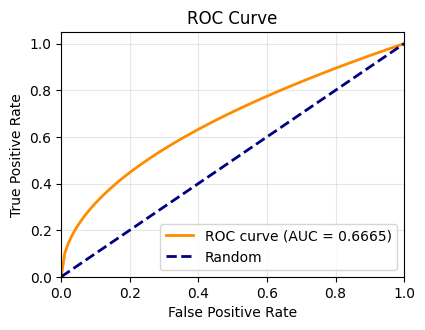

In [26]:
import matplotlib.pyplot as plt


plt.figure(figsize=(16, 6))     

ax2 = plt.subplot(2, 4, 2)
ax2.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.4f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random')
ax2.set_xlim(0.0, 1.0)
ax2.set_ylim(0.0, 1.05)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve', fontsize=12)
ax2.legend(loc="lower right")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

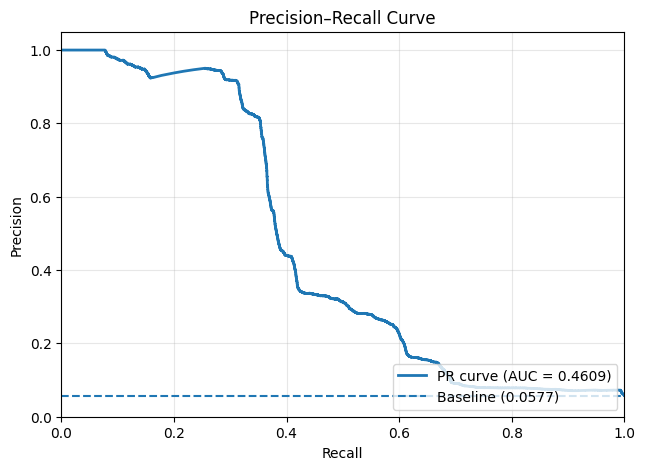

In [33]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(12, 5))
gs  = fig.add_gridspec(1, 4,
    width_ratios=[1, 2, 2, 1], 
    wspace=0.3
)

ax = fig.add_subplot(gs[0, 1:3])

ax.plot(recall, precision, lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
baseline = np.mean(point_labels)
ax.axhline(baseline, linestyle='--', label=f'Baseline ({baseline:.4f})')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1.05)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision–Recall Curve', fontsize=12)
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)

plt.show()

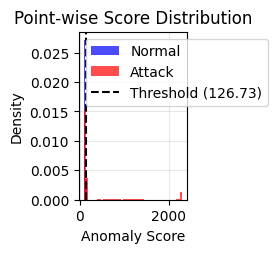

In [17]:
# 4. Score Distribution
ax4 = plt.subplot(2, 4, 4)
normal_scores = point_scores[point_labels == 0]
attack_scores = point_scores[point_labels == 1]
ax4.hist(normal_scores, bins=50, alpha=0.7, label='Normal', density=True, color='blue')
ax4.hist(attack_scores, bins=50, alpha=0.7, label='Attack', density=True, color='red')
ax4.axvline(thresh, color='black', linestyle='--', label=f'Threshold ({thresh:.2f})')
ax4.set_xlabel('Anomaly Score')
ax4.set_ylabel('Density')
ax4.set_title('Point-wise Score Distribution', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)

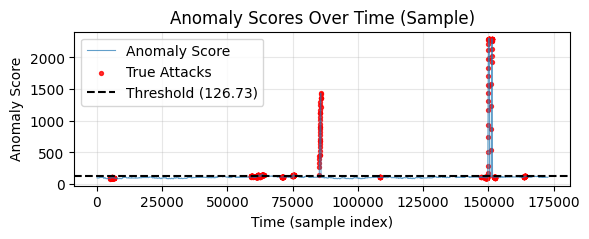

In [34]:
# 5. Time series plot of scores (sample) - spans full width
ax5 = plt.subplot(2, 1, 2)
sample_size = min(10000, len(point_scores))
sample_idx = np.linspace(0, len(point_scores)-1, sample_size, dtype=int)
ax5.plot(sample_idx, point_scores[sample_idx], alpha=0.7, label='Anomaly Score', linewidth=0.8)
attack_points = sample_idx[point_labels[sample_idx] == 1]
ax5.scatter(attack_points, 
           point_scores[attack_points], 
           color='red', s=8, alpha=0.8, label='True Attacks')
ax5.axhline(thresh, color='black', linestyle='--', label=f'Threshold ({thresh:.2f})')
ax5.set_xlabel('Time (sample index)')
ax5.set_ylabel('Anomaly Score')
ax5.set_title('Anomaly Scores Over Time (Sample)', fontsize=12)
ax5.legend()
ax5.grid(True, alpha=0.3)

plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust spacing instead of tight_layout
plt.show()

In [29]:
print(f"\n=== THRESHOLD ANALYSIS ===")
print(f"Selected threshold: {thresh:.4f}")
print(f"% of training data above threshold: {(scores_train_norm > thresh).mean()*100:.2f}%")

# Find optimal threshold based on F1-score
f1_scores = []
thresholds_range = np.linspace(point_scores.min(), point_scores.max(), 100)
for t in thresholds_range:
    y_pred_t = (point_scores > t).astype(int)
    f1_t = f1_score(point_labels, y_pred_t, pos_label=1)
    f1_scores.append(f1_t)

optimal_thresh_idx = np.argmax(f1_scores)
optimal_thresh = thresholds_range[optimal_thresh_idx]
optimal_f1 = f1_scores[optimal_thresh_idx]

print(f"Optimal threshold (F1-based): {optimal_thresh:.4f}")
print(f"Optimal F1-score: {optimal_f1:.4f}")

# Performance at optimal threshold
y_pred_optimal = (point_scores > optimal_thresh).astype(int)
optimal_recall = recall_score(point_labels, y_pred_optimal, pos_label=1)
optimal_precision = precision_recall_curve(point_labels, point_scores)[0][np.argmin(np.abs(precision_recall_curve(point_labels, point_scores)[2] - optimal_thresh))]

print(f"Performance at optimal threshold:")
print(f"  Precision: {optimal_precision:.4f}")
print(f"  Recall: {optimal_recall:.4f}")
print(f"  F1-score: {optimal_f1:.4f}")

# Summary table
print(f"\n=== PERFORMANCE SUMMARY ===")
print(f"{'Metric':<20} {'Value':<10}")
print(f"{'-'*30}")
print(f"{'ROC-AUC':<20} {roc_auc:<10.4f}")
print(f"{'PR-AUC':<20} {pr_auc:<10.4f}")
print(f"{'F1-Score':<20} {tp_f1:<10.4f}")
print(f"{'Recall':<20} {tp_recall:<10.4f}")
print(f"{'Precision':<20} {classification_report(point_labels, y_pred_points, output_dict=True)['1']['precision']:<10.4f}")
print(f"{'Accuracy':<20} {classification_report(point_labels, y_pred_points, output_dict=True)['accuracy']:<10.4f}")

print("\nPoint-wise evaluation completed!")


=== THRESHOLD ANALYSIS ===
Selected threshold: 126.7287
% of training data above threshold: 1.00%
Optimal threshold (F1-based): 129.0071
Optimal F1-score: 0.4764
Performance at optimal threshold:
  Precision: 0.8263
  Recall: 0.3347
  F1-score: 0.4764

=== PERFORMANCE SUMMARY ===
Metric               Value     
------------------------------
ROC-AUC              0.6665    
PR-AUC               0.4609    
F1-Score             0.4694    
Recall               0.3652    
Precision            0.6568    
Accuracy             0.9523    

Point-wise evaluation completed!
